# Diabetes Prediction using SVM's and Root Finding

#### By: Parker Pratt

### Abstract:

This study investigates diabetes prediction using Support Vector Machines (SVMs) and explores the effectiveness of feature selection through root-finding and regression techniques. With the PIMA Indian Diabetes dataset, I applied SVMs with linear, polynomial, sigmoid, and radial basis function kernels to predict diabetes based on key features. Using techniques like ElasticNet for feature weighting and grid search for hyperparameter optimization, I identified optimal feature sets and parameter configurations for accurate classification. Results show how different kernels compare, and how Numerical Root-finding Methods stack up against classic Data Science methods. The study underscores the importance of interpretability and model tuning in predictive healthcare applications, providing insights for improving diagnostic algorithms in diabetes care.

# Introduction:

Accurate classification of biomedical data plays a critical role in healthcare applications, enabling early detection of diseases. This project explores multiple optimization techniques including Newton's Method, the Secant Method, and the Bisection Method. These are then applied to logistic regression for binary classification. Additionally, support vector machines (SVMs) with various kernels are implemented, and their hyperparameters are optimized using grid and randomized search. By comparing the methods on a dataset with features such as glucose levels and BMI, this study aims to provide insights into their effectiveness in improving classification accuracy and reducing error rates. 

Key findings reveal that Newton's Method and SVMs with optimized parameters achieve the highest accuracy on the test data, while the Secant and Bisection methods show limitations in convergence. Among SVM kernels, the linear kernel performs comparably to more complex kernels when the hyperparameter C is finely tuned.

This analysis extends existing knowledge by combining optimization algorithms with machine learning models, shedding light on their practical applications and computational trade-offs. Understanding these methods is crucial as biomedical datasets grow in complexity and precision, requiring robust algorithms for reliable classification.

# Mathematical/Technological Methods Used:

This section outlines the mathematical principles and computational techniques implemented in the project to address the classification problem, optimize model parameters, and evaluate performance.

## Logistic Regression and Newton’s Method
The core of this analysis is logistic regression, a probabilistic model used for binary classification. Logistic regression predicts the probability of a sample belonging to a specific class using the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}},
$$

where $z = X \cdot w$ represents the linear combination of features $X$ and weights $w$. The weights are optimized by minimizing a regularized cost function:

$$
J(w) = -\frac{1}{m} \sum_{i=1}^m \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right] + \frac{\lambda}{2} \sum_{j=1}^n w_j^2,
$$

where $m$ is the number of samples, $y_i$ is the true label, $\hat{y}_i$ is the predicted probability, and $\lambda$ is the regularization parameter to prevent overfitting.

Newton’s method is employed to optimize $w$. The method iteratively updates weights using:

$$
w_{t+1} = w_t - H^{-1} \cdot \nabla J(w_t),
$$

where $H$ is the Hessian matrix (second derivative of $J(w)$), and $\nabla J(w_t)$ is the gradient of the cost function at step $t$.

## Secant and Bisection Methods
Alternative optimization methods, including the Secant and Bisection methods, were implemented to explore non-derivative and interval-based optimization strategies.

- **Secant Method:** This quasi-Newton method avoids explicit computation of the Hessian matrix by estimating gradient differences iteratively.
- **Bisection Method:** An interval halving approach is used to locate the optimal weights, narrowing down the search space until convergence criteria or maximum iterations are met.

## Support Vector Machines (SVM)
To extend the analysis, SVMs were utilized with four different kernels: linear, polynomial, radial basis function (RBF), and sigmoid. The SVM algorithm aims to maximize the margin between classes by solving the following optimization problem:

$$
\min_w \frac{1}{2} ||w||^2 + C \sum_{i=1}^m \max(0, 1 - y_i (w \cdot x_i + b)),
$$

where $C$ is a regularization parameter, $x_i$ are the features, and $y_i$ are the labels.

## Model Selection and Hyperparameter Tuning
Hyperparameter optimization was performed using `GridSearchCV` and `RandomizedSearchCV`. `RandomizedSearchCV` is a randomized search method for identifying the optimal $C$ parameter for SVMs. This approach samples $C$ values from a uniform distribution and evaluates performance across cross-validation folds. `GridSearchCV` is similar but iterates through a provided list instead of using random values.

## Data Preprocessing and Scaling
Data preprocessing involved splitting the dataset into training and test sets, scaling features to zero mean and unit variance using the `StandardScaler`, and adding a bias term for intercept calculations. Usually, a $70-30$ split was used with $70%$ of the data in the training set and $30%$ in the testing set. However, the training set was shrunk later on due to unforseen increased performance.

## Performance Metrics
The models were evaluated using:
- **Confusion Matrix:** To quantify true positives, false positives, true negatives, and false negatives.
- **Accuracy Score:** Defined as:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}.
$$

These metrics were calculated for each model and hyperparameter configuration to assess predictive performance.


# Key Findings/Results:

In [1]:
#Load necessary packages
import pandas as pd
import numpy as np
import pandasql as psql

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import sklearn.model_selection as skm

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from scipy.stats import uniform

Dataset was downloaded here: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [2]:
#Read in dataset
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Find baseline accuracies
o=0
t=0
for i in range(len(df['Insulin'])):
    if df['Outcome'][i] != 0:
        o+=1
    t+=1
print("Only predicting 1 gives us an accuracy of: " + str(o/t))
print("Only predicting 0 gives us an accuracy of: " + str(1-(o/t)))

Only predicting 1 gives us an accuracy of: 0.3489583333333333
Only predicting 0 gives us an accuracy of: 0.6510416666666667


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe(include = "all")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


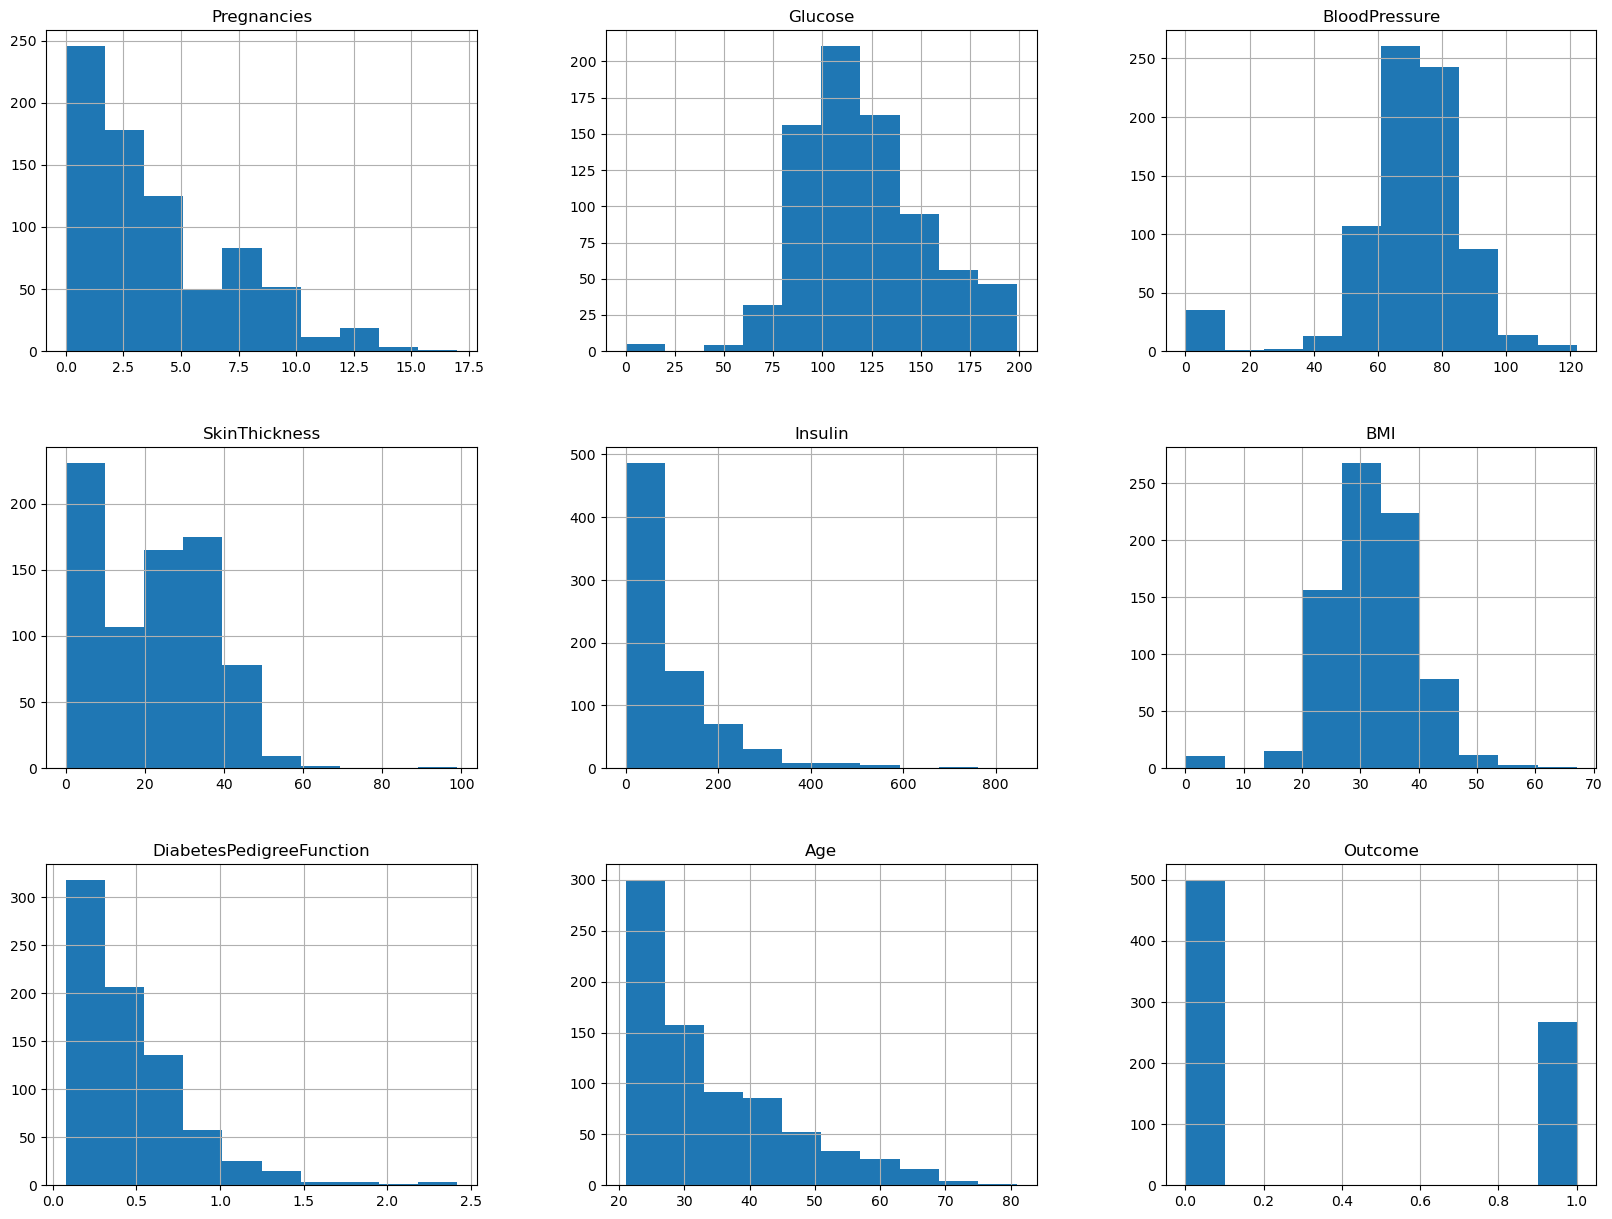

In [7]:
df.hist(figsize = (20,15))
plt.show()

##### This plot shows histograms of data spread with each feature.

In [8]:
df.corr(numeric_only = True)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [9]:
#Train-test split with 'Outcome' as the response variable
X = df.drop(columns = 'Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [10]:
#Make the pipeline and the grid for the grid search
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet()),
])

grid = {
    'elasticnet__alpha': [0.1, 0.5, 1, 2, 5],
    'elasticnet__l1_ratio': [0.05, 0.2, 0.5, 0.8, 0.95],
    'feature_selection__k': range(1,8)
}

In [11]:
import warnings
warnings.filterwarnings('ignore')

grid_search = GridSearchCV(pipeline, param_grid = grid, cv=5, scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x0000011212C7F010>)),
                                       ('scaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.1, 0.5, 1, 2, 5],
                         'elasticnet__l1_ratio': [0.05, 0.2, 0.5, 0.8, 0.95],
                         'feature_selection__k': range(1, 8)},
             scoring='neg_mean_squared_error')

In [12]:
cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)
results_df = results_df.drop(columns=['params'])

In [13]:
best_model = grid_search.best_estimator_

test_scores = cross_val_score(best_model, X_test, y_test, cv=5, scoring = 'neg_mean_squared_error')
mse_scores = -test_scores
mse_scores

array([0.18253689, 0.14602128, 0.14977343, 0.17954052, 0.16481442])

In [14]:
tuned_params = grid_search.best_params_

elastic_net_model = best_model.named_steps['elasticnet']
coefficients = elastic_net_model.coef_

feature_selection = best_model.named_steps['feature_selection']

feature_names = X_train.columns.tolist()
selected_indices = feature_selection.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_indices]

Final Choice of Parameters
{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.05, 'feature_selection__k': 6}


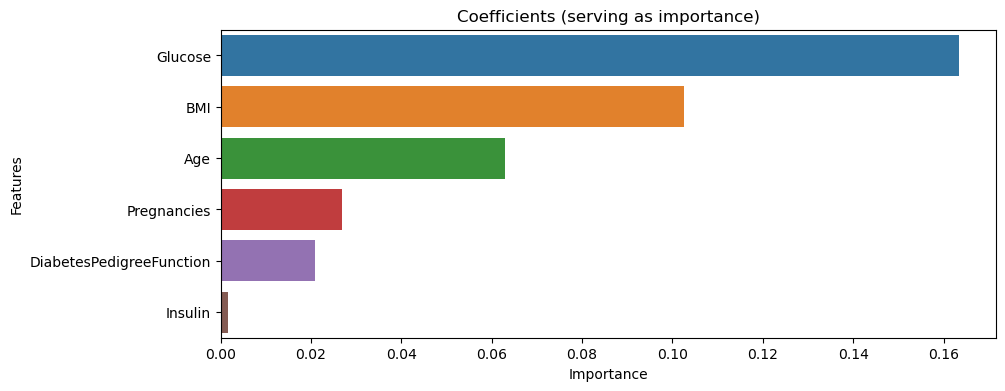

In [15]:
#Plot the importance of each parameter
model_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

model_features_df ['Importance'] = model_features_df['Coefficient'].abs()
model_features_df = model_features_df.sort_values(by='Importance', ascending=False)

print("Final Choice of Parameters")
print(tuned_params)

plt.figure(figsize=(10,4))
sns.barplot(x = 'Importance', y="Feature", data = model_features_df)
plt.title('Coefficients (serving as importance)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

##### Glucose and BMI are the most important features for predicting the outcome so these will be used for 2-Dimensional predictions.

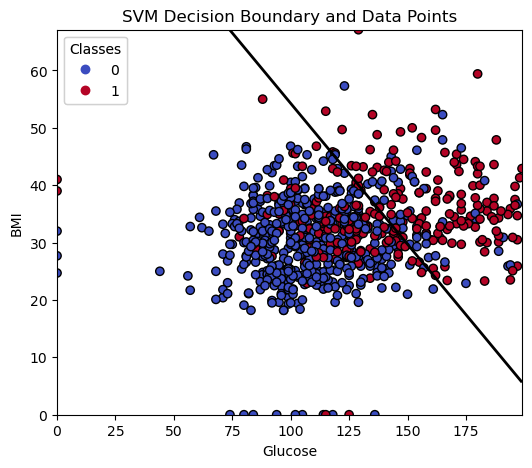

In [16]:
#Isolate most important features
X_data_2d = df[['Glucose', 'BMI']].values
X_train_2d = X_train[['Glucose', 'BMI']].values
X_test_2d = X_test[['Glucose', 'BMI']].values

# Train the SVM again using only the first two features
svm_2d = SVC(kernel='linear')
svm_2d.fit(X_train_2d, y_train)

# Create a meshgrid for plotting decision boundaries
xx, yy = np.meshgrid(np.linspace(X_data_2d[:, 0].min(), X_data_2d[:, 0].max(), 100),
                     np.linspace(X_data_2d[:, 1].min(), X_data_2d[:, 1].max(), 100))

# Predict values over the meshgrid
Z = svm_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margins
fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary and margins
ax.contour(xx, yy, Z, levels=[0], colors='black', linestyles='solid', linewidths=2, label="SVM Decision Boundary")

# Plot the training data points
scatter = ax.scatter(X_data_2d[:, 0], X_data_2d[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title("SVM Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### This plot looks as good as it gets for a linear regression model on this data.

In [17]:
# Predict and calculate accuracy
y_pred = svm_2d.predict(X_test_2d)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7489177489177489


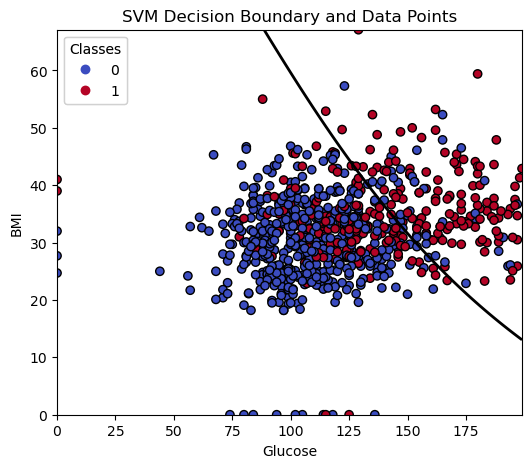

In [18]:
# Train the SVM again using only the first two features
svm_2d2 = SVC(kernel='poly')
svm_2d2.fit(X_train_2d, y_train)

# Predict values over the meshgrid
Z2 = svm_2d2.decision_function(np.c_[xx.ravel(), yy.ravel()])  # Decision function for SVM
Z2 = Z2.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary and margins
scatter = ax.scatter(X_data_2d[:, 0], X_data_2d[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.contour(xx, yy, Z2, levels=[0], colors='black', linestyles='solid', linewidths=2, label="SVM Decision Boundary")

ax.set_title("SVM Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### A polynomial kernel does about the same as the linear kernel but slightly worse.

In [19]:
# Predict and calculate accuracy
y_pred2 = svm_2d2.predict(X_test_2d)
svm_accuracy = accuracy_score(y_test, y_pred2)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7402597402597403


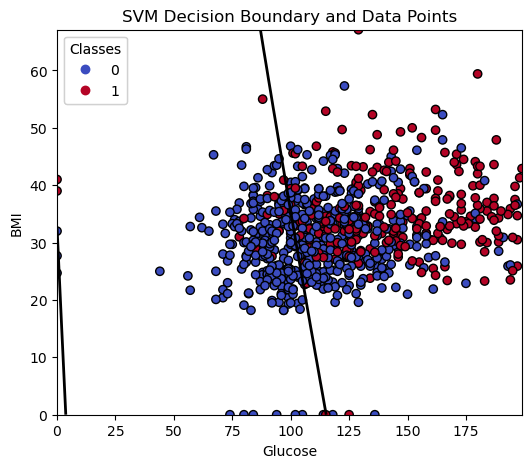

In [20]:
# Train the SVM again using only the first two features
svm_2d3 = SVC(kernel='sigmoid')
svm_2d3.fit(X_train_2d, y_train)

# Predict values over the meshgrid
Z3 = svm_2d3.decision_function(np.c_[xx.ravel(), yy.ravel()])  # Decision function for SVM
Z3 = Z3.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary and margins
scatter = ax.scatter(X_data_2d[:, 0], X_data_2d[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.contour(xx, yy, Z3, levels=[0], colors='black', linestyles='solid', linewidths=2, label="SVM Decision Boundary")

ax.set_title("SVM Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### Sigmoid does absolutely awful with only these two features as predictors.

In [21]:
# Predict and calculate accuracy
y_pred3 = svm_2d3.predict(X_test_2d)
svm_accuracy = accuracy_score(y_test, y_pred3)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.39826839826839827


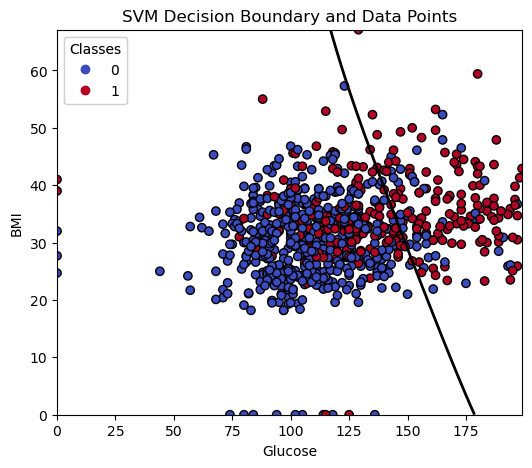

In [22]:
# Train the SVM again using only the first two features
svm_2d4 = SVC(kernel='rbf')
svm_2d4.fit(X_train_2d, y_train)

# Predict values over the meshgrid
Z4 = svm_2d4.decision_function(np.c_[xx.ravel(), yy.ravel()])  # Decision function for SVM
Z4 = Z4.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary and margins
scatter = ax.scatter(X_data_2d[:, 0], X_data_2d[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.contour(xx, yy, Z4, levels=[0], colors='black', linestyles='solid', linewidths=2, label="SVM Decision Boundary")

ax.set_title("SVM Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### RBF does about the same as the linear and polynomial kernels.

In [23]:
# Predict and calculate accuracy
y_pred4 = svm_2d4.predict(X_test_2d)
svm_accuracy = accuracy_score(y_test, y_pred4)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7359307359307359


### Functions to be used in Newton's Method:

In [24]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(w, X, y, lambda_=0.1):
    z = X.dot(w)
    predictions = sigmoid(z)
    cost = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    regularization = (lambda_ / 2) * np.sum(w[1:]**2)  # Exclude bias term
    return cost + regularization

def gradient(w, X, y, lambda_=0):
    y = np.array(y).reshape(-1)  # Ensure y is a 1D array
    z = X.dot(w)
    predictions = sigmoid(z)  # Sigmoid function applied to linear combination
    grad = X.T.dot(predictions - y) / len(y)
    grad[1:] += lambda_ * w[1:]  # Add regularization term (exclude bias)
    return grad

# Hessian matrix (second derivative)
def hessian(w, X, y):
    z = X.dot(w)
    predictions = sigmoid(z)
    S = np.diag(predictions * (1 - predictions))  # Diagonal matrix of weights
    return X.T.dot(S).dot(X) / len(y)

# Newton's Method
def newton_method(X, y, max_iter=5, tol=1e-6):
    w = np.zeros(X.shape[1])  # Initialize weights
    for _ in range(max_iter):
        grad = gradient(w, X, y)
        H = hessian(w, X, y)
        delta_w = np.linalg.inv(H).dot(grad)
        w -= delta_w
        if np.linalg.norm(delta_w) < tol:
            break
    return w

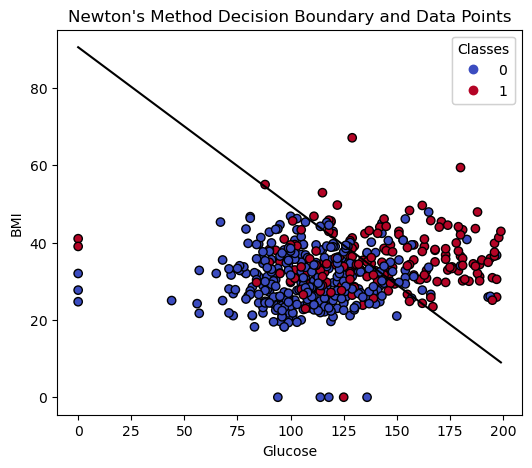

In [25]:
# Train model using Newton's method
X_train_bias = np.c_[np.ones(X_train_2d.shape[0]), X_train_2d]
X_test_bias = np.c_[np.ones(X_test_2d.shape[0]), X_test_2d]

w_opt = newton_method(X_train_bias, y_train)

x_range = np.linspace(X_train_2d[:, 0].min(), X_train_2d[:, 0].max(), 100)

if np.abs(w_opt[2]) > 1e-6:  # Ensure w_opt[2] is not too small
    decision_boundary = -(w_opt[0] + w_opt[1] * x_range) / w_opt[2]
else:
    print("Warning: w_opt[2] is too small, decision boundary might be miscalculated.")
    decision_boundary = np.zeros_like(x_range)

# Plot decision boundary and margins
fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary
ax.plot(x_range, decision_boundary, color='black', label="Decision Boundary")

# Plot the training data points
scatter = ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Set titles and labels
ax.set_title("Newton's Method Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### Looks very similar to the SVM with a linear kernel. Matter of fact, the accuracy value is the exact same!

In [26]:
def predict(X, w):
    return (np.dot(X, w) >= 0.5).astype(int)

# Add bias term
X_test_bias = np.c_[np.ones(X_test_2d.shape[0]), X_test_2d]

# Predict using the optimized weights
y_pred = predict(X_test_bias, w_opt)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

[[136  15]
 [ 43  37]]
Accuracy: 0.7489177489177489


In [27]:
def secant_method(X, y, max_iter=5, tol=1e-6):
    w_prev = np.zeros(X.shape[1])  # Initial guess (w_0)
    w_curr = np.random.rand(X.shape[1])  # Second guess (w_1)

    for _ in range(max_iter):
        grad_prev = gradient(w_prev, X, y)
        grad_curr = gradient(w_curr, X, y)

        # Calculate the gradient difference
        grad_diff = grad_curr - grad_prev

        # Avoid division by zero
        if np.linalg.norm(grad_diff) < tol:
            print("Gradient difference too small; exiting.")
            break

        # Update weights using Secant formula
        delta_w = ((w_curr - w_prev).dot(grad_curr)) / grad_diff.dot(grad_curr)
        w_next = w_curr - delta_w * grad_curr

        # Convergence check
        if np.linalg.norm(w_next - w_curr) < tol:
            break

        w_prev, w_curr = w_curr, w_next

    return w_curr

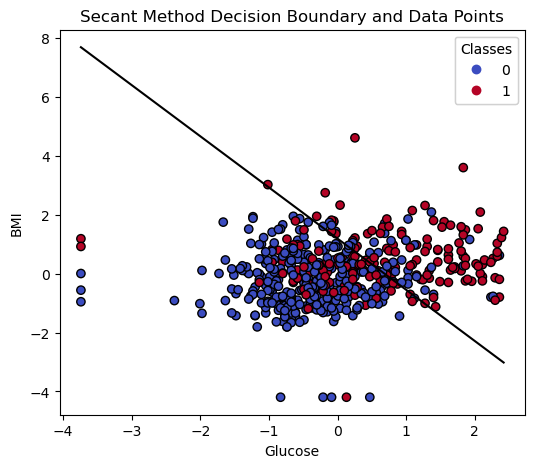

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)  # Scale the training set
X_test_scaled = scaler.transform(X_test_2d)  # Scale the test set

X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

w_opt = secant_method(X_train_bias, y_train)

x_range = np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 100)

if np.abs(w_opt[2]) > 1e-6:  # Ensure w_opt[2] is not too small
    decision_boundary = -(w_opt[0] + w_opt[1] * x_range) / w_opt[2]
else:
    print("Warning: w_opt[2] is too small, decision boundary might be miscalculated.")
    decision_boundary = np.zeros_like(x_range)

# Plot decision boundary and margins
fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary
ax.plot(x_range, decision_boundary, color='black', label="Decision Boundary")

# Plot the training data points
scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Set titles and labels
ax.set_title("Secant Method Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### With $5$ as the max iterations, the Secant Method performed the exact same as Newton's Method.

In [29]:
# Predict using the optimized weights
y_pred_s = predict(X_test_bias, w_opt)

# Confusion matrix
cm_s = confusion_matrix(y_test, y_pred_s)
print(cm_s)

accuracy = accuracy_score(y_test, y_pred_s)
print(f"Accuracy: {accuracy}")

[[136  15]
 [ 43  37]]
Accuracy: 0.7489177489177489


In [30]:
def bisection_method(X, y, max_iter=5, tol=1e-6):
    # Initialize weight vectors for the bounds (randomly or based on prior knowledge)
    w_a = np.zeros(X.shape[1])  # Lower bound
    w_b = np.random.rand(X.shape[1])  # Upper bound

    def loss_derivative(w):
        return gradient(w, X, y)

    for i in range(max_iter):
        # Compute midpoint weight vector
        w_mid = (w_a + w_b) / 2
        grad_mid = loss_derivative(w_mid)

        # Convergence check
        if np.linalg.norm(grad_mid) < tol or np.linalg.norm(w_b - w_a) / 2 < tol:
            print(f"Converged in {i+1} iterations.")
            return w_mid

        # Narrow the interval
        if np.dot(loss_derivative(w_a), grad_mid) < 0:
            w_b = w_mid
        else:
            w_a = w_mid
            
    return w_mid

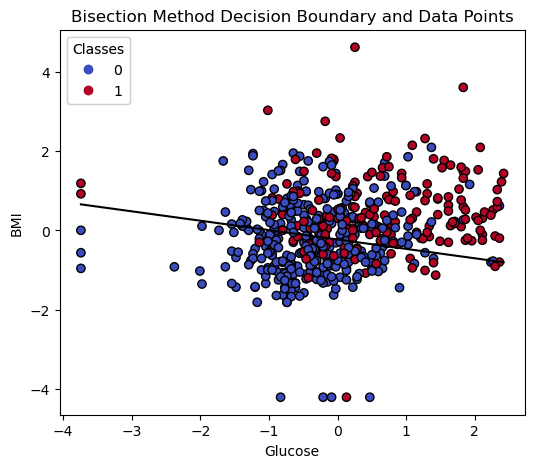

In [31]:
X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

w_opt = bisection_method(X_train_bias, y_train)

x_range = np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 100)

if np.abs(w_opt[2]) > 1e-6:  # Ensure w_opt[2] is not too small
    decision_boundary = -(w_opt[0] + w_opt[1] * x_range) / w_opt[2]
else:
    print("Warning: w_opt[2] is too small, decision boundary might be miscalculated.")
    decision_boundary = np.zeros_like(x_range)

# Plot decision boundary and margins
fig, ax = plt.subplots(figsize=(6, 5))

# Plot decision boundary
ax.plot(x_range, decision_boundary, color='black', label="Decision Boundary")

# Plot the training data points
scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')

# Set titles and labels
ax.set_title("Bisection Method Decision Boundary and Data Points")
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")

# Add a legend for the scatter plot
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Show the plot
plt.show()

##### Bisection Method does much worse than Newton's Method and Secant Method. With an accuracy score worse than the baseline.

In [32]:
# Predict using the optimized weights
y_pred_s = predict(X_test_bias, w_opt)

# Confusion matrix
cm_s = confusion_matrix(y_test, y_pred_s)
print(cm_s)

accuracy = accuracy_score(y_test, y_pred_s)
print(f"Accuracy: {accuracy}")

[[100  51]
 [ 39  41]]
Accuracy: 0.6103896103896104


In [33]:
#Accuracy is higher when train_size is 0.3 than 0.7?
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, y, train_size=0.3, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)  # Scale the training set
X_test_scaled = scaler.transform(X_test) # Scale the test set

In [34]:
param_dist = {
    'C': uniform(loc=0.01, scale=10)  # Samples C from 0.01 to 10 (uniformly distributed)
}

svc_rbf = SVC(kernel='rbf', random_state=42)
svc_poly = SVC(kernel='poly', random_state=42)
svc_sig = SVC(kernel='sigmoid', random_state=42)
svc_lin = SVC(kernel='linear', random_state=42)

In [35]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svc_rbf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random samples to try
    scoring='accuracy',
    cv=5,
    random_state=42
)

# Set up RandomizedSearchCV
random_search2 = RandomizedSearchCV(
    estimator=svc_poly,
    param_distributions=param_dist,
    n_iter=20,  # Number of random samples to try
    scoring='accuracy',
    cv=5,
    random_state=42
)

# Set up RandomizedSearchCV
random_search3 = RandomizedSearchCV(
    estimator=svc_sig,
    param_distributions=param_dist,
    n_iter=20,  # Number of random samples to try
    scoring='accuracy',
    cv=5,
    random_state=42
)

# Set up RandomizedSearchCV
random_search4 = RandomizedSearchCV(
    estimator=svc_lin,
    param_distributions=param_dist,
    n_iter=20,  # Number of random samples to try
    scoring='accuracy',
    cv=5,
    random_state=42
)

In [36]:
# Fit the random search
random_search.fit(X_train_scaled, y_train)
random_search2.fit(X_train_scaled, y_train)
random_search3.fit(X_train_scaled, y_train)
random_search4.fit(X_train_scaled, y_train)

# Get the best C value
best_C_random = random_search.best_params_['C']
print(f"Optimal C (RBF Kernel, Random Search): {best_C_random}")
best_C_random = random_search2.best_params_['C']
print(f"Optimal C (Poly Kernel, Random Search): {best_C_random}")
best_C_random = random_search3.best_params_['C']
print(f"Optimal C (Sigmoid Kernel, Random Search): {best_C_random}")
best_C_random = random_search4.best_params_['C']
print(f"Optimal C (Linear Kernel, Random Search): {best_C_random}")

Optimal C (RBF Kernel, Random Search): 2.1333911067827613
Optimal C (Poly Kernel, Random Search): 3.7554011884736247
Optimal C (Sigmoid Kernel, Random Search): 0.21584494295802448
Optimal C (Linear Kernel, Random Search): 3.7554011884736247


In [37]:
# Train the model with the best C
best_model_random = random_search.best_estimator_
best_model_random2 = random_search2.best_estimator_
best_model_random3 = random_search3.best_estimator_
best_model_random4 = random_search4.best_estimator_

# Predict on training and test data
y_hat_train = best_model_random.predict(X_train_scaled)
y_hat_test = best_model_random.predict(X_test_scaled)
y_hat_train2 = best_model_random2.predict(X_train_scaled)
y_hat_test2 = best_model_random2.predict(X_test_scaled)
y_hat_train3 = best_model_random3.predict(X_train_scaled)
y_hat_test3 = best_model_random3.predict(X_test_scaled)
y_hat_train4 = best_model_random4.predict(X_train_scaled)
y_hat_test4 = best_model_random4.predict(X_test_scaled)

# Calculate error rates
train_error_rate_random = 1 - accuracy_score(y_train, y_hat_train)
test_error_rate_random = 1 - accuracy_score(y_test, y_hat_test)
train_error_rate_random2 = 1 - accuracy_score(y_train, y_hat_train2)
test_error_rate_random2 = 1 - accuracy_score(y_test, y_hat_test2)
train_error_rate_random3 = 1 - accuracy_score(y_train, y_hat_train3)
test_error_rate_random3 = 1 - accuracy_score(y_test, y_hat_test3)
train_error_rate_random4 = 1 - accuracy_score(y_train, y_hat_train4)
test_error_rate_random4 = 1 - accuracy_score(y_test, y_hat_test4)

print(f"Training Error Rate RBF(Random Search): {train_error_rate_random:.4f}")
print(f"Test Error Rate RBF(Random Search): {test_error_rate_random:.4f}")
print(f"Training Error Rate Poly(Random Search): {train_error_rate_random2:.4f}")
print(f"Test Error Rate Poly(Random Search): {test_error_rate_random2:.4f}")
print(f"Training Error Rate Sigmoid(Random Search): {train_error_rate_random3:.4f}")
print(f"Test Error Rate Sigmoid(Random Search): {test_error_rate_random3:.4f}")
print(f"Training Error Rate Linear(Random Search): {train_error_rate_random4:.4f}")
print(f"Test Error Rate Linear(Random Search): {test_error_rate_random4:.4f}")

Training Error Rate RBF(Random Search): 0.1391
Test Error Rate RBF(Random Search): 0.2639
Training Error Rate Poly(Random Search): 0.1478
Test Error Rate Poly(Random Search): 0.2825
Training Error Rate Sigmoid(Random Search): 0.2696
Test Error Rate Sigmoid(Random Search): 0.2305
Training Error Rate Linear(Random Search): 0.2348
Test Error Rate Linear(Random Search): 0.2212


In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_hat_test)
cm2 = confusion_matrix(y_test, y_hat_test2)
cm3 = confusion_matrix(y_test, y_hat_test3)
cm4 = confusion_matrix(y_test, y_hat_test4)

print("Confusion Matrix RBF:")
print(cm)
print("Accuracy is " + str((cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])))

print("Confusion Matrix Poly:")
print(cm2)
print("Accuracy is " + str((cm2[0][0]+cm2[1][1])/(cm2[0][0]+cm2[1][1]+cm2[0][1]+cm2[1][0])))

print("Confusion Matrix Sigmoid:")
print(cm3)
print("Accuracy is " + str((cm3[0][0]+cm3[1][1])/(cm3[0][0]+cm3[1][1]+cm3[0][1]+cm3[1][0])))

print("Confusion Matrix Linear:")
print(cm4)
print("Accuracy is " + str((cm4[0][0]+cm4[1][1])/(cm4[0][0]+cm4[1][1]+cm4[0][1]+cm4[1][0])))

Confusion Matrix RBF:
[[284  65]
 [ 77 112]]
Accuracy is 0.7360594795539034
Confusion Matrix Poly:
[[317  32]
 [120  69]]
Accuracy is 0.7174721189591078
Confusion Matrix Sigmoid:
[[319  30]
 [ 94  95]]
Accuracy is 0.7695167286245354
Confusion Matrix Linear:
[[302  47]
 [ 72 117]]
Accuracy is 0.7788104089219331


##### Sigmoid is much better now that it is using all of the predictors. Polynomial is surprisingly worse and Linear and RBF are about the same as before. With SVM Linear being the best method used.

# Summary:

The goal of this project was to compare different linear regression methods to be able to predict diabetes. After these tests, we see that Numerical Root-Finding Methods are comparable to classic Data Science methods. Newton's Method and Secant Method shared the exact same accuracy score as a linear SVM which I did not expect. However, the downside to these Numerical Methods are that in more than two dimensions, they can be extremely difficult to implement and are much less efficient than traditional SVM's. 

Some shortcomings of this report were that only linear regression methods were used when for this dataset, there are other methods that would give much better results. Another shortcoming is how only accuracy was used as a scoring metric which could leave out information that might help with understanding the data. 

This study has broad implications across fields such as healthcare, finance, marketing, and social sciences, providing a simple yet powerful tool for binary classification tasks. In addition, logistic regression serves as a foundation for more complex machine learning models, offering computational efficiency and insight into feature significance. By improving prediction accuracy, logistic regression remains essential for building effective predictive models in real-world applications.

# References

##### Logistic Regression: https://papers.tinbergen.nl/02119.pdf
##### Cost Function: https://rss.onlinelibrary.wiley.com/doi/10.1111/j.2517-6161.1958.tb00292.x
##### Support Vector Machines: https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_3
##### Hyperparameter Optimization: https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf
##### Accuracy: https://stackoverflow.com/questions/37665680/how-does-sklearn-compute-the-accuracy-score-step-by-step
##### Prof. Joseph Reid 
##### Dr. Pake Melland